IN PROGRESS

TODO:
- add sympy to subcirucit classes
- add ac sim tool; try to do an inhertince from last section
- add rl complimeint filters
- create table of low-high pass vs rc & rl
- add rlc resonce
- add rlc filters
- add filter desighn tool and filter cirucit generation tool
- discues L->C passive conversion

In [1]:
#%%writefile AC_2_Codes.py
#Library import statements

from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import YouTubeVideo, display

import traceback
import warnings

In [2]:
#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

Software,Version
Python,3.7.6 64bit [GCC 7.3.0]
IPython,7.12.0
OS,Linux 4.19.104 microsoft standard x86_64 with debian bullseye sid
skidl,0.0.31.dev0
PySpice,1.4.3
lcapy,0.70
sympy,1.6.2
numpy,1.18.1
matplotlib,3.3.0
pandas,1.1.4


# Basic Passive Filters

## The low pass filter from ALL ABOUT ELECTRONICS "RC Low Pass Filter Explained"  @~ 8:35min

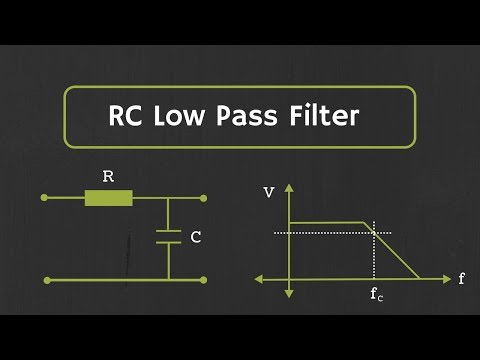

In [3]:
YouTubeVideo('_2L0l-E1Wx0', width=500, height=400, start=515)

In [4]:
class rc_lowpass():
    def __init__(self, subcirc_ref=None, C_value=1@u_F, R_value=1@u_Ohm):
        """
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Termanls are defined via:
        ```
       Left_Termanals - RC_Lowpass - Right_Termanals
                          +----+  
        Postive V_i        0-|0  2|-2     Postive V_o
        Negtive V_i        1-|1  3|-3     Negtive V_o
                          +----+
        ```
        """
        
        self.c=C(value=self.C_value)
        self.r=R(value=self.R_value)
        
        self.r[1, 2]+=term_0, self.c['p']
        self.c['p', 'n']+=term_2, term_3
        
        
        
        
        if return_elements:
            return self.c, self.r
    
    def draw_me(self):
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'R 0_1 2_1; right, l=R{str(self.R_value)}')
        self.schematic.add(f'C 2_1 1_1; down, l=C{str(self.C_value)}')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')

        
        self.schematic.draw()
        
        
    

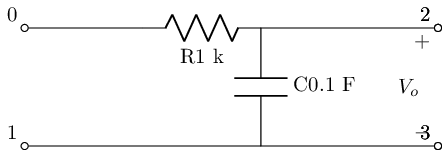

In [5]:
lowpassF=rc_lowpass(C_value=.1@u_uF, R_value=1@u_kOhm)
lowpassF.draw_me()

In [6]:
reset()
net_1=Net('N1'); net_2=Net('N2'); 

vs=SINEV(ac_magnitude=10@u_V, dc_value=10@u_V)
vs['p', 'n']+=net_1, gnd
lowpassF.SKiDl(net_1, gnd, net_2, gnd)




circ=generate_netlist()
print(circ)

.title 
C1 N2 0 0.1uF
R1 N1 N2 1kOhm
V1 N1 0 DC 0V AC 10V 0.0rad SIN(0V 1V 50Hz 0s 0Hz)




No errors or warnings found during netlist generation.



In [11]:
class ac_ease():
    def __init__(self, circ_netlist_obj):
        self.circ_netlist_obj=circ_netlist_obj
        self._build_table()
        
        #dic of allowed AC sweep types
        self.allowed_steptypes_map={'linear':'lin', 'decade':'dec', 'octave': 'oct'}

    
    def _build_table(self):
        self.fsweep_DF=pd.DataFrame(columns=['Start_freq', 'Stop_Freq', 'SamplingInc', 'StepType'])
        self.fsweep_DF.at[len(self.fsweep_DF)]=[.1@u_Hz, 120@u_GHz, 10, 'decade']

    def ac_sweep_setup(self, Start_freq, Stop_Freq, SamplingInc, StepType, display=False):
        """
        TODO:
            -add display action
        """
        #check for allwed step types
        assert StepType in self.allowed_steptypes_map.keys(),  f"{StepType} is not allowed"
        #force start to non zero if sweep not linear
        if StepType != 'linear':
            if float(Start_freq)==0:
                warnings.warn('"linear" is only sweep type that can start at 0Hz,\n setting starting frequancy to 1e-1Hz')
                Start_freq=1e-1@u_Hz
                
                
        
        self.fsweep_DF.at[0]=[Start_freq, Stop_Freq, SamplingInc, StepType]
    
    def _make_sim_control(self):
        
        #check the control table struct
        assert (self.fsweep_DF.columns==['Start_freq', 'Stop_Freq', 'SamplingInc', 'StepType']).all(), 'Contorl Table Column structer has been altered'
        
        #will probily change this down the road
        assert len(self.fsweep_DF)==1, 'there should only be one entry in the control table'
        
        #check the sweep type
        self.fsweep_DF['StepType'][0] in self.allowed_steptypes_map.keys(), f"{self.fsweep_DF['StepType'][0]} is not allowed"
        
        #force start to non zero if sweep not linear
        if self.fsweep_DF['StepType'][0] != 'linear':
            if float(self.fsweep_DF['Start_freq'][0])==0:
                warnings.warn('"linear" is only sweep type that can start at 0Hz,\n setting starting frequancy to 1e-1Hz')
                self.fsweep_DF.at[0, 'Start_freq']=1e-1@u_Hz
        
        self.ac_control={
            'start_frequency':self.fsweep_DF.at[0, 'Start_freq'], 
            'stop_frequency':self.fsweep_DF.at[0, 'Stop_Freq'], 
            'number_of_points':self.fsweep_DF.at[0, 'SamplingInc'],
            'variation': self.allowed_steptypes_map[self.fsweep_DF.at[0, 'StepType']]
        }
        
        
        
    
    def do_ac_sim(self):
        self._make_sim_control()
        self.sim=self.circ_netlist_obj.simulator()
        self.ac_vals=self.sim.ac(**self.ac_control)
        
        self.record_ac_nodebranch()

    
    def record_ac_nodebranch(self):
        self.ac_resultsNB_DF=pd.DataFrame(index=self.ac_vals.frequency.as_ndarray())
        self.ac_resultsNB_DF.index.name='freq[Hz]'
        
        #get the node voltages
        for n in self.circ_netlist_obj.node_names:
            if n=='0':
                continue
            self.ac_resultsNB_DF[n+'_[V]']=self.ac_vals[n].as_ndarray()
        
        #get the current from any voltage sourcs
        for cm in self.circ_netlist_obj.element_names:
            if 'V'==cm[0]:
                self.ac_resultsNB_DF[cm+'_[A]']=-self.ac_vals[cm].as_ndarray()
        

In [12]:
#test of current source
#reset()
#net_1=Net('N1'); net_2=Net('N2')
#cs=SINEI(ac_magnitude=1@u_A); cs['p', 'n']+=gnd, net_1
#c1=C(value=1@u_F); c1['p', 'n']+=net_1, gnd
#l1=L(value=1@u_H); l1[1,2]+=net_1, net_2
#rload=R(value=100@u_Ohm); rload[1, 2]+=net_2, gnd

#circ=generate_netlist()
#print(circ)

In [13]:
ac_sweep=ac_ease(circ)
ac_sweep.fsweep_DF

,Start_freq,Stop_Freq,SamplingInc,StepType
0,0.1 Hz,120 GHz,10,decade


In [15]:
ac_sweep.do_ac_sim()
ac_sweep.ac_resultsNB_DF

,N2_[V],N1_[V],V1_[A]
freq[Hz],,,
1.000000e-01,1.000000e+01-6.283185e-04j,10.000000+0.000000j,3.947842e-11+6.283185e-07j
1.258925e-01,1.000000e+01-7.910061e-04j,10.000000+0.000000j,6.256907e-11+7.910062e-07j
1.584893e-01,1.000000e+01-9.958177e-04j,10.000000+0.000000j,9.916530e-11+9.958178e-07j
1.995262e-01,1.000000e+01-1.253660e-03j,10.000000+0.000000j,1.571664e-10+1.253660e-06j
2.511886e-01,1.000000e+01-1.578265e-03j,10.000000+0.000000j,2.490920e-10+1.578265e-06j
...,...,...,...
3.981072e+10,1.598234e-14-3.997791e-07j,10.000000+0.000000j,1.000000e-02+3.997792e-10j
5.011872e+10,1.008417e-14-3.175559e-07j,10.000000+0.000000j,1.000000e-02+3.175559e-10j
6.309573e+10,6.362683e-15-2.522436e-07j,10.000000+0.000000j,1.000000e-02+2.522436e-10j


In [ ]:
ac_sweep.circ_netlist_obj.element_names

In [ ]:
# .ac will not record current
#ac_sweep.ac_vals['I1']

In [ ]:
ac_sweep.fsweep_DF.at[0, 'Start_freq']=0
ac_sweep.fsweep_DF

In [16]:
sim=circ.simulator()

In [ ]:
#ac_vals=sim.ac(start_frequency=1e-1@u_Hz, stop_frequency=120@u_GHz, number_of_points=10, variation='dec')
ac_vals=sim.ac(start_frequency=0@u_Hz, stop_frequency=10e3@u_Hz, number_of_points=10000, variation='lin')
#=sim.ac(start_frequency=1e-1@u_Hz, stop_frequency=1@u_THz, number_of_points=10, variation='oct')

In [ ]:
v_i=ac_vals[node(net_1)]
v_o=ac_vals[node(net_2)]
f=ac_vals.frequency

In [ ]:
plt.semilogx(f, 10*np.log10(np.abs(v_o)))
plt.twinx()
plt.semilogx(f, np.rad2deg(np.unwrap(np.angle(v_o))), color='g')

In [ ]:
v_i

In [ ]:
v_o_time=np.fft.fftshift(np.fft.ifft(v_o))
plt.plot(np.abs(v_o_time))

In [ ]:
#pz_vals=sim.pole_zero(node(net_1), node(gnd), node(net_2), node(gnd), 'vol', 'pz')

## Equivlint Low Pass RL filter 

The eqivlint RL filter to the above RC filter may be found via the equivlint time consitnc of the RC and RL implemntaiotn such that time constance must mach ie:
$$RC=\tau_{RC}=\tau_{RL}=L/R$$

In [ ]:
(1e3)**2 *.1e-9

In [ ]:
class rl_lowpass():
    def __init__(self, subcirc_ref=None, L_value=1@u_H, R_value=1@u_Ohm):
        """
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Termanls are defined via:
        ```
       Left_Termanals - RL_Lowpass - Right_Termanals
                          +----+  
        Postive V_i        0-|0  2|-2     Postive V_o
        Negtive V_i        1-|1  3|-3     Negtive V_o
                          +----+
        ```
        """
        
        self.l=L(value=self.L_value)
        self.r=R(value=self.R_value)
        
        self.l['p', 'n']+=term_0, term_2
        self.r[1, 2]+=self.l['n'], term_1
        
        
        
        
        if return_elements:
            return self.l, self.r
    
    def draw_me(self):
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'L 0_1 2_1; right, l=L{str(self.L_value)}')
        self.schematic.add(f'R 2_1 1_1; down, l=R{str(self.R_value)}')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')

        
        self.schematic.draw()
        
        
    

In [ ]:
rl_l=rl_lowpass(L_value=(1e3)**2 *.1e-9 @u_H, R_value=1e3)
rl_l.draw_me()

In [ ]:
reset()
net_1=Net('N1'); net_2=Net('N2'); 

vs=SINEV(amplitude=10@u_V, frequency=2@u_kHz)
vs['p', 'n']+=net_1, gnd
rl_l.SKiDl(net_1, gnd, net_2, gnd)




circ=generate_netlist()
print(circ)

In [ ]:
sim=circ.simulator()

In [ ]:
ac_vals=sim.ac(start_frequency=1@u_Hz, stop_frequency=2@u_MHz, number_of_points=10, variation='dec')

In [ ]:
v_i=ac_vals[node(net_1)]
v_o=ac_vals[node(net_2)]
f=ac_vals.frequency

In [ ]:
plt.semilogx(f, 20*np.log10(np.abs(v_o)))
plt.twinx()
plt.semilogx(f, np.rad2deg(np.unwrap(np.angle(v_o))), color='g')

In [ ]:
v_o_time=np.fft.fftshift(np.fft.ifft(v_o))
plt.plot(np.abs(v_o_time))

## The high pass filter from ALL ABOUT ELECTRONICS "RC High Pass Filter Explained"  @~ 7:57min

In [ ]:
YouTubeVideo('9Dx0b0ukNAM', width=500, height=400, start=477)

In [ ]:
class rc_highpass():
    def __init__(self, subcirc_ref=None, C_value=1@u_F, R_value=1@u_Ohm):
        """
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.C_value=C_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Termanls are defined via:
        ```
       Left_Termanals - RC_Highpass - Right_Termanals
                          +----+  
        Postive V_i        0-|0  2|-2     Postive V_o
        Negtive V_i        1-|1  3|-3     Negtive V_o
                          +----+
        ```
        """
        
        self.c=C(value=self.C_value)
        self.r=R(value=self.R_value)
        
        self.c['p', 'n']+=term_0, term_2
        self.r[1, 2]+=self.c['n'], term_1
        
        
        
        
        if return_elements:
            return self.c, self.r
    
    def draw_me(self):
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'C 0_1 2_1; right, l=C{str(self.C_value)}')
        self.schematic.add(f'R 2_1 1_1; down, l=R{str(self.R_value)}')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')

        
        self.schematic.draw()
        
        
    

In [ ]:
highpassF=rc_highpass(C_value=1.5@u_nF, R_value=10@u_kOhm)
highpassF.draw_me()

In [ ]:
reset()
net_1=Net('N1'); net_2=Net('N2'); 

vs=SINEV(amplitude=10@u_V, frequency=10@u_kHz)
vs['p', 'n']+=net_1, gnd
highpassF.SKiDl(net_1, gnd, net_2, gnd)




circ=generate_netlist()
print(circ)

In [ ]:
sim=circ.simulator()

In [ ]:
ac_vals=sim.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10, variation='dec')

In [ ]:
v_i=ac_vals[node(net_1)]
v_o=ac_vals[node(net_2)]
f=ac_vals.frequency

In [ ]:
plt.semilogx(f, 20*np.log10(np.abs(v_o)))
plt.twinx()
plt.semilogx(f, np.rad2deg(np.unwrap(np.angle(v_o))), color='g')

In [ ]:
v_o_time=np.fft.fftshift(np.fft.ifft(v_o))
plt.plot(np.abs(v_o_time))

## RL Highpass

In [ ]:
class rl_highpass():
    def __init__(self, subcirc_ref=None, L_value=1@u_H, R_value=1@u_Ohm):
        """
        TODO:
            -add assertions
        """
        #add assertions
        self.subcirc_ref=subcirc_ref
        self.L_value=L_value
        self.R_value=R_value
        

    @subcircuit
    def SKiDl(self, term_0, term_1, term_2, term_3, return_elements=False):
        """
        Termanls are defined via:
        ```
       Left_Termanals - RL_Highpass - Right_Termanals
                          +----+  
        Postive V_i        0-|0  2|-2     Postive V_o
        Negtive V_i        1-|1  3|-3     Negtive V_o
                          +----+
        ```
        """
        
        self.l=L(value=self.L_value)
        self.r=R(value=self.R_value)
        
        self.r[1, 2]+=term_0, self.l['p']
        self.l['p', 'n']+=term_2, term_3
        
        
        
        
        if return_elements:
            return self.l, self.r
    
    def draw_me(self):
        self.schematic=kiwi.Circuit()
        self.schematic.add('W 1 1_1; right=2')
        self.schematic.add('W 0 0_1; right')
        #self.schematic.add('P1 0 1; down, v=V_i')
        
        self.schematic.add(f'R 0_1 2_1; right, l=R{str(self.R_value)}')
        self.schematic.add(f'L 2_1 1_1; down, l=L{str(self.L_value)}')
        
        self.schematic.add('W 2_1 2; right=1.5')
        self.schematic.add('W 1_1 3; right=1.5')
        self.schematic.add('P2 2 3; down, v=V_o')

        
        self.schematic.draw()
        
        
    

In [ ]:
(10e3)**2 *1.5e-9

In [ ]:
rl_h=rl_highpass(L_value=(10e3)**2 *1.5e-9 @u_H, R_value=10@u_kOhm)
rl_h.draw_me()

In [ ]:
reset()
net_1=Net('N1'); net_2=Net('N2'); 

vs=SINEV(amplitude=10@u_V, frequency=10@u_kHz)
vs['p', 'n']+=net_1, gnd
rl_h.SKiDl(net_1, gnd, net_2, gnd)




circ=generate_netlist()
print(circ)

In [ ]:
sim=circ.simulator()

In [ ]:
ac_vals=sim.ac(start_frequency=1@u_Hz, stop_frequency=1@u_MHz, number_of_points=10, variation='dec')

In [ ]:
v_i=ac_vals[node(net_1)]
v_o=ac_vals[node(net_2)]
f=ac_vals.frequency

In [ ]:
plt.semilogx(f, 20*np.log10(np.abs(v_o)))
plt.twinx()
plt.semilogx(f, np.rad2deg(np.unwrap(np.angle(v_o))), color='g')

In [ ]:
v_o_time=np.fft.fftshift(np.fft.ifft(v_o))
plt.plot(np.abs(v_o_time))

# Seconed Order filters

## The band pass filter from ALL ABOUT ELECTRONICS "Band Pass Filter and Band Stop Filter Explained"  @~ 4:03min

In [ ]:
YouTubeVideo('dmPIydL0lyM', width=500, height=400, start=243)

In [ ]:
reset()
net_1=Net('N1'); net_2=Net('N2'); net_3=Net('N3')

vs=SINEV(amplitude=10@u_V, frequency=10@u_kHz)
vs['p', 'n']+=net_1, gnd

highpassFsection=rc_highpass(C_value=1.5@u_nF, R_value=10@u_kOhm)
highpassFsection.SKiDl(net_1, gnd, net_2, gnd)

lowpassFsection=rc_lowpass(C_value=1.5@u_nF, R_value=1@u_kOhm)
lowpassFsection.SKiDl(net_2, gnd, net_3, gnd)


circ=generate_netlist()
print(circ)

In [ ]:
sim=circ.simulator()

In [ ]:
ac_vals=sim.ac(start_frequency=1@u_Hz, stop_frequency=50@u_MHz, number_of_points=10, variation='dec')

In [ ]:
v_i=ac_vals[node(net_1)]
v_o=ac_vals[node(net_3)]
f=ac_vals.frequency

In [ ]:
plt.semilogx(f, 20*np.log10(np.abs(v_o)))
plt.twinx()
plt.semilogx(f, np.rad2deg(np.unwrap(np.angle(v_o))), color='g')

In [ ]:
v_o_time=np.fft.fftshift(np.fft.ifft(v_o))
plt.plot(np.abs(v_o_time))

## Citations:
[1] ALL ABOUT ELECTRONICS. "RC Low Pass Filter Explained," YouTube, Aug 20, 2017. [Video file]. Available: https://youtu.be/_2L0l-E1Wx0. [Accessed: Nov 30, 2020].

[2] ALL ABOUT ELECTRONICS. "RC High Pass Filter Explained," YouTube, Aug 23, 2017. [Video file]. Available: https://youtu.be/9Dx0b0ukNAM. [Accessed: Nov 30, 2020].

[2] ALL ABOUT ELECTRONICS. "Band Pass Filter and Band Stop Filter Explained," YouTube, Sep 2, 2017. [Video file]. Available: https://youtu.be/dmPIydL0lyM. [Accessed: Nov 30, 2020].
